In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import json


In [ ]:
# Config
OUTPUT_DIR = "data/data_outputs_bank"
TOP_K = 5
SYN_SOURCES = ["ctgan", "tvae", "copula"]


In [ ]:
# Load real data
train_df = pd.read_csv(os.path.join(OUTPUT_DIR, "train_df_bank.csv"))
holdout_df = pd.read_csv(os.path.join(OUTPUT_DIR, "holdout_df_bank.csv"))

# Load synthetic data
synthetic_data = {
    name: pd.read_csv(os.path.join(OUTPUT_DIR, f"synthetic_{name}_bank.csv"))
    for name in SYN_SOURCES
}


In [ ]:
# Distance function
def get_membership_scores(real_df, synthetic_df):
    nn = NearestNeighbors(n_neighbors=TOP_K)
    nn.fit(synthetic_df)
    distances, _ = nn.kneighbors(real_df)
    return distances.mean(axis=1)


In [ ]:
# Distance based MIA
results = {}
all_distances = {}



for model, syn_df in synthetic_data.items():
    syn_df = syn_df[train_df.columns]


    train_scores = get_membership_scores(train_df, syn_df) 
    holdout_scores = get_membership_scores(holdout_df, syn_df)

    scores = -np.concatenate([train_scores, holdout_scores])
    labels = np.array([1] * len(train_scores) + [0] * len(holdout_scores))

    auc = roc_auc_score(labels, scores)
    precision = precision_score(labels, scores > np.median(scores))
    recall = recall_score(labels, scores > np.median(scores))
    fpr, tpr, _ = roc_curve(labels, scores)

    results[model] = {
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "fpr": fpr,
        "tpr": tpr
    }

    all_distances[model] = {
        "train": train_scores,
        "holdout": holdout_scores
    }

    print(f"{model.upper()} — Distance-based MIA AUC: {auc:.3f}")


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/si

CTGAN — Distance-based MIA AUC: 0.499


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/si

TVAE — Distance-based MIA AUC: 0.499


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/si

COPULA — Distance-based MIA AUC: 0.502


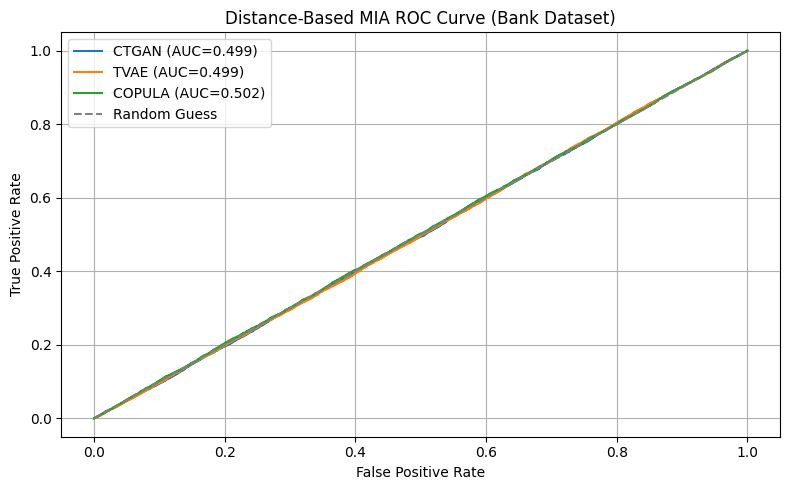

In [ ]:

# Plot ROC Curve
plt.figure(figsize=(8, 5))
for model in results:
    plt.plot(results[model]["fpr"], results[model]["tpr"], label=f"{model.upper()} (AUC={results[model]['auc']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Distance-Based MIA ROC Curve (Bank Dataset)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "mia_roc_curve_bank.png"))
plt.show()

In [ ]:

# Model-based MIA
model_mia_results = {}

for model in synthetic_data:
    train_dist = all_distances[model]["train"]
    holdout_dist = all_distances[model]["holdout"]

    X = np.concatenate([train_dist, holdout_dist]).reshape(-1, 1)
    y = np.array([1]*len(train_dist) + [0]*len(holdout_dist))

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)

    model_mia_results[model] = auc
    print(f"{model.upper()} — Model-based MIA AUC: {auc:.3f}")

with open(os.path.join(OUTPUT_DIR, "model_mia_auc_bank.json"), "w") as f:
    json.dump(model_mia_results, f, indent=2)


CTGAN — Model-based MIA AUC: 0.504
TVAE — Model-based MIA AUC: 0.494
COPULA — Model-based MIA AUC: 0.504


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_st

In [ ]:

# Worst case MIA

print("\n--- Worst-Case MIA: Top 10% Vulnerable ---")
worst_case_auc_results = {}

for model in synthetic_data:
    train_dist = all_distances[model]["train"]
    holdout_dist = all_distances[model]["holdout"]

    top_k_train = np.argsort(train_dist)[:int(0.1 * len(train_dist))]
    top_k_holdout = np.argsort(holdout_dist)[:int(0.1 * len(holdout_dist))]

    X = np.concatenate([train_dist[top_k_train], holdout_dist[top_k_holdout]]).reshape(-1, 1)
    y = np.array([1]*len(top_k_train) + [0]*len(top_k_holdout))

    clf = LogisticRegression()
    clf.fit(X, y)
    y_pred = clf.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_pred)

    worst_case_auc_results[model] = auc
    print(f"{model.upper()} — Worst-Case AUC: {auc:.3f}")

    

with open(os.path.join(OUTPUT_DIR, "worst_case_mia_auc_bank.json"), "w") as f:
    json.dump(worst_case_auc_results, f, indent=2)


--- Worst-Case MIA: Top 10% Vulnerable ---
CTGAN — Worst-Case AUC: 0.524
TVAE — Worst-Case AUC: 0.529
COPULA — Worst-Case AUC: 0.503


/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: invalid value encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/brandon/Documents/synth_data_proj/synth_data_proj_venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_st